In [1]:
pip install -U transformers


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 85.8 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 558.8/558.8 kB 31.5 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.33.1
    Uninstalling huggingface-hub-0.33.1:
      Successfully uninstalled huggingface-hub-0.33.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.52.4
    Uninstalling transformers-4.52.4:
      Successfully uninstalled transformers-4.52.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 3.6.0 requires fsspec[http]<=2025.3.0,>=2023.1.0, but you have fsspec 2025.5.1 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import re
import torch
import random
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModel,AutoModelForSequenceClassification, Trainer, TrainingArguments,EarlyStoppingCallback
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import seaborn as sns 
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

2025-07-31 05:34:06.568410: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753940046.750363      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753940046.805564      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
df = pd.read_csv("/content/mtsamples.csv", on_bad_lines='skip')

In [4]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4999 entries, 0 to 4998
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         4999 non-null   int64 
 1   description        4999 non-null   object
 2   medical_specialty  4999 non-null   object
 3   sample_name        4999 non-null   object
 4   transcription      4966 non-null   object
 5   keywords           3931 non-null   object
dtypes: int64(1), object(5)
memory usage: 234.5+ KB


,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords
0,0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."


In [5]:
df.isnull().sum()

Unnamed: 0              0
description             0
medical_specialty       0
sample_name             0
transcription          33
keywords             1068
dtype: int64

Data preprocessing - (removing null values,preprocessing text,encoding the medical_specialty)

In [6]:
#Considered only the rows which has transcription values (removing the 33 rows)
df = df[df["transcription"].notna()].reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4966 entries, 0 to 4965
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         4966 non-null   int64 
 1   description        4966 non-null   object
 2   medical_specialty  4966 non-null   object
 3   sample_name        4966 non-null   object
 4   transcription      4966 non-null   object
 5   keywords           3898 non-null   object
dtypes: int64(1), object(5)
memory usage: 232.9+ KB


In [7]:
df = df.drop_duplicates(subset=['transcription'])
df = df.reset_index(drop=True)
df.shape

(2357, 6)

In [8]:
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
lemmatizer    = WordNetLemmatizer()
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    # Removing the stopword too here itself
    tokens = text.split()
    filtered_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    text = ' '.join(filtered_tokens)
    return text
# Removing the stopword too here itself

df['final_transcription'] = df['transcription'].apply(clean_text)
df['final_keywords'] = df['keywords'].fillna('').apply(clean_text)
df['final_description'] = df['description'].fillna('').apply(clean_text)

df[['transcription', 'final_transcription']].head()
df[['keywords', 'final_keywords']].head()
df[['description', 'final_description']].head()

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,description,final_description
0,A 23-year-old white female presents with comp...,yearold white female present complaint allergy
1,Consult for laparoscopic gastric bypass.,consult laparoscopic gastric bypass
2,Consult for laparoscopic gastric bypass.,consult laparoscopic gastric bypass
3,2-D M-Mode. Doppler.,mmode doppler
4,2-D Echocardiogram,echocardiogram


so there are 40 different medical_specialties .so we need to encode them into number

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


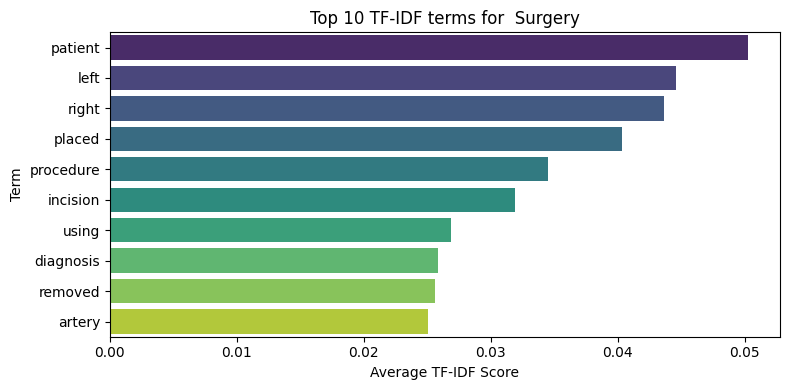

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


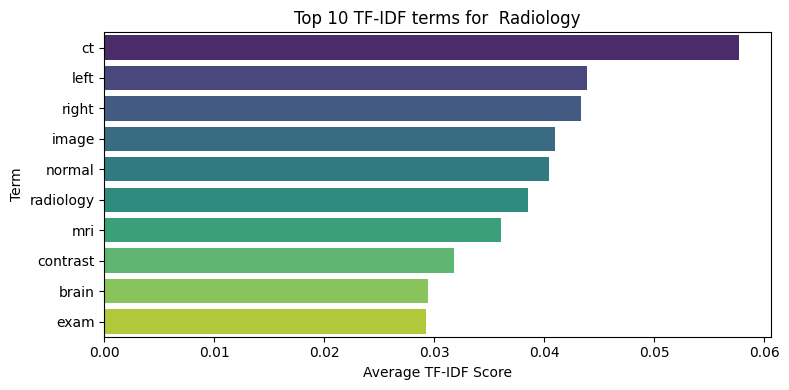

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


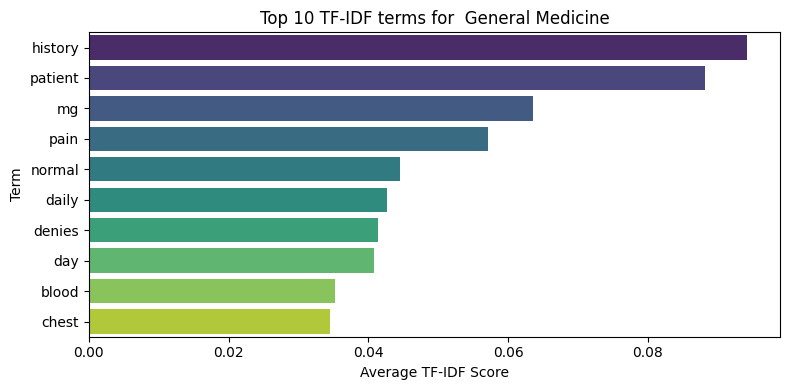

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


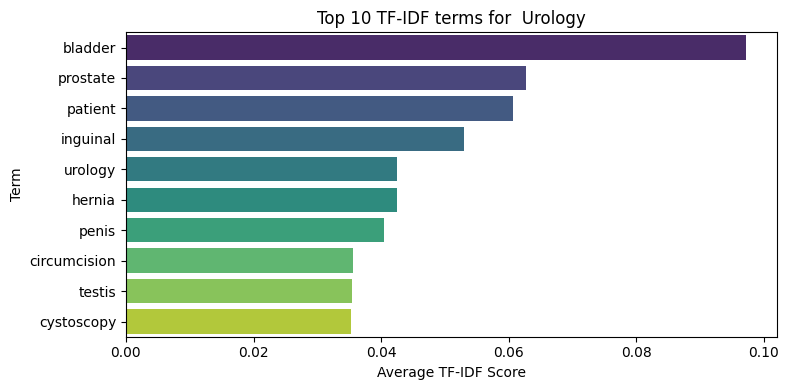

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


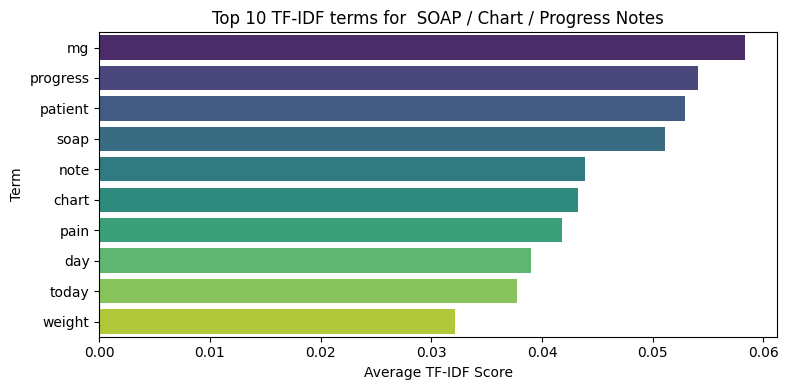

In [10]:
df['full_text'] = (
    df['final_description'].fillna('').astype(str) + ' ' +
    df['final_keywords'].fillna('').astype(str) + ' ' +
    df['final_transcription'].fillna('').astype(str)
)
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_tfidf = vectorizer.fit_transform(df['full_text'])
feature_names = vectorizer.get_feature_names_out()
def plot_top_tfidf_terms_for_class(class_name, top_n=10):
    mask = (df['medical_specialty'] == class_name).to_numpy()

    class_tfidf = X_tfidf[mask].mean(axis=0).A1

    # pick top terms
    topn_ids     = class_tfidf.argsort()[-top_n:][::-1]
    top_features = [feature_names[i] for i in topn_ids]
    top_scores   = class_tfidf[topn_ids]

    # plot
    plt.figure(figsize=(8, 4))
    sns.barplot(x=top_scores, y=top_features, palette='viridis')
    plt.title(f'Top {top_n} TF-IDF terms for {class_name}')
    plt.xlabel('Average TF-IDF Score')
    plt.ylabel('Term')
    plt.tight_layout()
    plt.show()

selected_specialties = df['medical_specialty'].value_counts().head(5).index
for specialty in selected_specialties:
    plot_top_tfidf_terms_for_class(specialty, top_n=10)

In [11]:
class_counts = df['medical_specialty'].value_counts()
# print(class_counts)
df = df[df['medical_specialty'].isin(class_counts[class_counts > 1].index)].reset_index(drop=True)
class_counts = df['medical_specialty'].value_counts()
print(class_counts)

medical_specialty
Surgery                          976
Radiology                        248
General Medicine                 157
Urology                          156
SOAP / Chart / Progress Notes    144
Neurology                         67
Orthopedic                        56
Consult - History and Phy.        55
Pediatrics - Neonatal             52
Psychiatry / Psychology           51
Pain Management                   45
Office Notes                      41
Hematology - Oncology             31
Gastroenterology                  31
Cardiovascular / Pulmonary        26
Obstetrics / Gynecology           26
Nephrology                        20
Discharge Summary                 17
Sleep Medicine                    17
Emergency Room Reports            17
ENT - Otolaryngology              16
Ophthalmology                     15
Bariatrics                        10
Podiatry                          10
Physical Medicine - Rehab         10
IME-QME-Work Comp etc.             9
Speech - Language   

In [12]:
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['medical_specialty'])
num_labels = len(label_encoder.classes_)
print(num_labels)

35


In [13]:
print(f"Number of labels: {num_labels}")
print(f"Label mapping: {dict(zip(label_encoder.classes_, range(num_labels)))}")
print(f"Dataset shape after cleaning: {df.shape}")

Number of labels: 35
Label mapping: {' Autopsy': 0, ' Bariatrics': 1, ' Cardiovascular / Pulmonary': 2, ' Chiropractic': 3, ' Consult - History and Phy.': 4, ' Cosmetic / Plastic Surgery': 5, ' Dermatology': 6, ' Discharge Summary': 7, ' ENT - Otolaryngology': 8, ' Emergency Room Reports': 9, ' Gastroenterology': 10, ' General Medicine': 11, ' Hematology - Oncology': 12, ' Hospice - Palliative Care': 13, ' IME-QME-Work Comp etc.': 14, ' Lab Medicine - Pathology': 15, ' Letters': 16, ' Nephrology': 17, ' Neurology': 18, ' Obstetrics / Gynecology': 19, ' Office Notes': 20, ' Ophthalmology': 21, ' Orthopedic': 22, ' Pain Management': 23, ' Pediatrics - Neonatal': 24, ' Physical Medicine - Rehab': 25, ' Podiatry': 26, ' Psychiatry / Psychology': 27, ' Radiology': 28, ' Rheumatology': 29, ' SOAP / Chart / Progress Notes': 30, ' Sleep Medicine': 31, ' Speech - Language': 32, ' Surgery': 33, ' Urology': 34}
Dataset shape after cleaning: (2353, 11)


In [14]:
def build_input(row):
    return f"{row['final_description']} {row['final_keywords']} {row['final_transcription']}"

df['bert_input'] = df.apply(build_input, axis=1)

In [15]:
X_trainval, X_test, Y_trainval, Y_test = train_test_split(
    df['bert_input'],
    df['label'],
    test_size=0.2,
    stratify=df['label'],
    random_state=42
)
X_train, X_val, Y_train, Y_val = train_test_split(
    X_trainval,
    Y_trainval,
    test_size=0.1,
    stratify=Y_trainval,
    random_state=42
)

print("Train size:", len(X_train))
print("Validation size:", len(X_val))
print("Test size:", len(X_test))

Train size: 1693
Validation size: 189
Test size: 471


Tokenize training data

In [16]:
# MODEL_NAME = "medicalai/ClinicalBERT"
# MODEL_NAME = "achDev/medicalBert"
MODEL_NAME = "emilyalsentzer/Bio_ClinicalBERT"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

Using base model embedding and using the LogisticRegression for classification

In [17]:
def extract_embeddings(texts, tokenizer, model, device, max_length=256):
    """Extract [CLS] embeddings for a list of texts."""
    all_embeddings = []
    model.eval()
    with torch.no_grad():
        for text in tqdm(texts, desc="Extracting embeddings", unit="sample"):
            inputs = tokenizer(text, max_length=max_length, truncation=True, padding='max_length', return_tensors='pt')
            inputs = {k: v.to(device) for k, v in inputs.items()}
            outputs = model(**inputs)
            cls_emb = outputs.last_hidden_state[:, 0, :].cpu().numpy()
            all_embeddings.append(cls_emb.squeeze())
    return np.vstack(all_embeddings)

In [18]:
from tqdm.auto import tqdm
base_model = AutoModel.from_pretrained(MODEL_NAME,num_labels=num_labels)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_model.to(device)

for param in base_model.parameters():
    param.requires_grad = False
X_train_emb = extract_embeddings(list(X_train), tokenizer, base_model, device)
X_val_emb = extract_embeddings(list(X_val), tokenizer, base_model, device)
X_test_emb = extract_embeddings(list(X_test), tokenizer, base_model, device)

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

Extracting embeddings:   0%|          | 0/1693 [00:00<?, ?sample/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Extracting embeddings:   0%|          | 0/189 [00:00<?, ?sample/s]

Extracting embeddings:   0%|          | 0/471 [00:00<?, ?sample/s]

In [19]:
classifier = LogisticRegression(max_iter=1000)
classifier.fit(X_train_emb, Y_train)
y_base_pred = classifier.predict(X_val_emb)

used_labels = np.unique(np.concatenate([Y_val, y_base_pred]))
label_names = label_encoder.classes_[used_labels]

print("\nBaseline ClinicalBERT + Logistic Regression on validation")
print(classification_report(Y_val, y_base_pred, target_names=label_names,
    labels=used_labels))
print("Accuracy:", accuracy_score(Y_val, y_base_pred))


Baseline ClinicalBERT + Logistic Regression on validation
                                precision    recall  f1-score   support

                       Autopsy       0.00      0.00      0.00         1
                    Bariatrics       0.00      0.00      0.00         1
    Cardiovascular / Pulmonary       0.00      0.00      0.00         2
    Consult - History and Phy.       0.50      0.50      0.50         4
             Discharge Summary       0.00      0.00      0.00         1
          ENT - Otolaryngology       0.00      0.00      0.00         1
        Emergency Room Reports       0.00      0.00      0.00         1
              Gastroenterology       0.00      0.00      0.00         3
              General Medicine       0.37      0.77      0.50        13
         Hematology - Oncology       0.00      0.00      0.00         2
        IME-QME-Work Comp etc.       0.00      0.00      0.00         1
                       Letters       0.00      0.00      0.00         1
    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
y_test_pred = classifier.predict(X_test_emb)
used_labels = np.unique(np.concatenate([Y_val, y_test_pred]))
label_names = label_encoder.classes_[used_labels]
print("\nBaseline ClinicalBERT + Logistic Regression on test data")
print(classification_report(Y_test, y_test_pred, target_names=label_names,
    labels=used_labels))
print("Accuracy:", accuracy_score(Y_test, y_test_pred))


Baseline ClinicalBERT + Logistic Regression on test data
                                precision    recall  f1-score   support

                       Autopsy       1.00      0.50      0.67         2
                    Bariatrics       0.00      0.00      0.00         2
    Cardiovascular / Pulmonary       1.00      0.60      0.75         5
    Consult - History and Phy.       0.29      0.45      0.36        11
             Discharge Summary       0.50      0.50      0.50         4
          ENT - Otolaryngology       0.00      0.00      0.00         3
        Emergency Room Reports       0.50      0.33      0.40         3
              Gastroenterology       0.50      0.17      0.25         6
              General Medicine       0.41      0.59      0.49        32
         Hematology - Oncology       0.38      0.50      0.43         6
        IME-QME-Work Comp etc.       1.00      0.50      0.67         2
                       Letters       0.00      0.00      0.00         1
     

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fine tuning the Clinical bert

In [21]:
X_train_enc = tokenizer(X_train.tolist(), truncation=True, padding="max_length", max_length=512)
X_val_enc = tokenizer(X_val.tolist(), truncation=True, padding="max_length", max_length=512)
X_test_enc = tokenizer(X_test.tolist(), truncation=True, padding="max_length", max_length=512)

In [22]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.encodings['input_ids'][idx]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][idx]),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

train_dataset = Dataset(X_train_enc, list(Y_train))
val_dataset = Dataset(X_val_enc, list(Y_val))
test_dataset = Dataset(X_test_enc, list(Y_test))

In [23]:
import os
os.environ["WANDB_DISABLED"] = "true"
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [25]:
def validate_labels(dataset, num_labels, name="dataset"):
    invalid_labels = []
    for i in range(len(dataset)):
        label = dataset[i]["labels"].item()
        if not (0 <= label < num_labels):
            invalid_labels.append((i, label))
    if invalid_labels:
        print(f"❗ Invalid labels in {name}: {invalid_labels}")
    else:
        print(f"✅ All labels valid in {name}")
validate_labels(train_dataset, num_labels, "train")
validate_labels(val_dataset, num_labels, "validation")
validate_labels(test_dataset, num_labels, "validation")

✅ All labels valid in train
✅ All labels valid in validation
✅ All labels valid in validation


In [26]:
print("Max label in training set:", max(Y_train))
print("Min label in training set:", min(Y_train))
# print("Num labels:", num_labels)
print("Unique labels:", sorted(set(Y_train)))

Max label in training set: 34
Min label in training set: 0
Unique labels: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34]


In [27]:

def compute_metrics(eval_pred):
    preds, labels = eval_pred
    preds = np.argmax(preds, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }

In [32]:
from sklearn.utils.class_weight import compute_class_weight
from transformers import get_linear_schedule_with_warmup
from torch.optim import AdamW 


batch_size = 4
num_epochs = 20

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels,
)

# optim = AdamW(model.parameters(), lr=1e-5, weight_decay=0.01)

# total_steps = (len(train_dataset) // batch_size) * num_epochs

# scheduler = get_linear_schedule_with_warmup(
#     optim,
#     num_warmup_steps=int(0.1 * total_steps),
#     num_training_steps=total_steps
# )

# weights = compute_class_weight("balanced", classes=np.arange(num_labels), y=Y_train)
# weight_tensor = torch.tensor(weights, device=device, dtype=torch.float)

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy = "epoch",
    logging_dir="./logs",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=num_epochs,
    weight_decay=0.01,
    learning_rate=2e-5,
    report_to="none",
    load_best_model_at_end=True,           
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    warmup_steps=200,              
    lr_scheduler_type='linear'
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    # optimizers=(optim, scheduler),
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)
trainer.train()
output_dir = "./best_clinicalbert_model"
trainer.save_model(output_dir)     
tokenizer.save_pretrained(output_dir)

print(f"Model and tokenizer saved to {output_dir}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,2.547500,1.844595,0.539683,0.421643,0.539683,0.451161
2,1.677000,1.445435,0.661376,0.574316,0.661376,0.591726
3,1.217100,1.043890,0.740741,0.703147,0.740741,0.705141
4,0.837400,0.857299,0.793651,0.751574,0.793651,0.757514
5,0.617300,0.686372,0.830688,0.798395,0.830688,0.800999
6,0.410000,0.573275,0.883598,0.864320,0.883598,0.865938
7,0.273800,0.558601,0.873016,0.852771,0.873016,0.853501
8,0.180900,0.565424,0.867725,0.844127,0.867725,0.842860
9,0.122700,0.528007,0.873016,0.861123,0.873016,0.860811
10,0.084200,0.517633,0.888889,0.882791,0.888889,0.877511


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will

Model and tokenizer saved to ./best_clinicalbert_model


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classif


Validation Classification Report:
                                precision    recall  f1-score   support

                       Autopsy       0.00      0.00      0.00         1
                    Bariatrics       0.00      0.00      0.00         1
    Cardiovascular / Pulmonary       1.00      0.50      0.67         2
    Consult - History and Phy.       0.67      0.50      0.57         4
             Discharge Summary       0.00      0.00      0.00         1
          ENT - Otolaryngology       0.00      0.00      0.00         1
        Emergency Room Reports       0.00      0.00      0.00         1
              Gastroenterology       1.00      0.33      0.50         3
              General Medicine       0.71      0.92      0.80        13
         Hematology - Oncology       0.67      1.00      0.80         2
        IME-QME-Work Comp etc.       1.00      1.00      1.00         1
                       Letters       0.00      0.00      0.00         1
                    Nephrolo

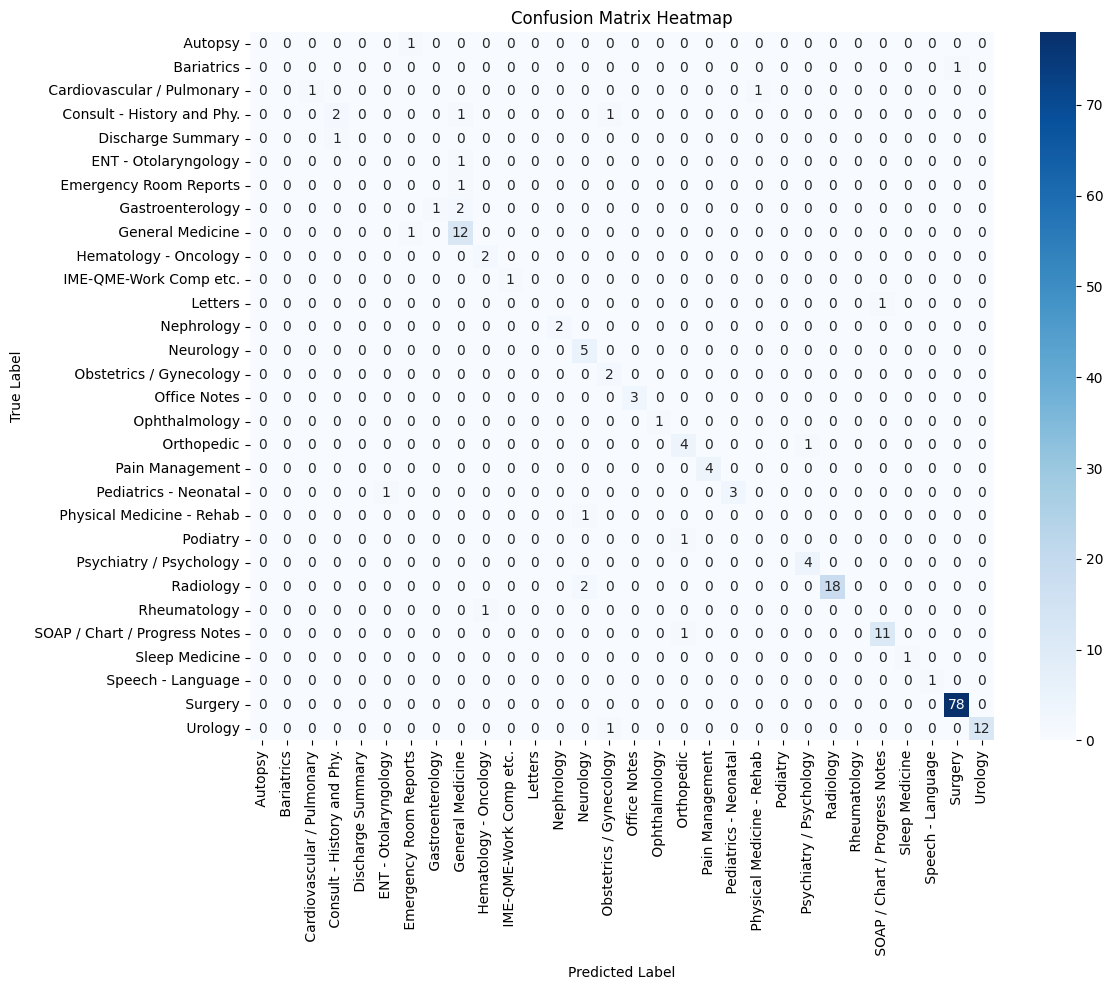

In [33]:
import seaborn as sns 
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

pred_out = trainer.predict(val_dataset)
y_val_pred = np.argmax(pred_out.predictions, axis=1)
y_val_true = pred_out.label_ids

used_labels = np.unique(np.concatenate([y_val_true, y_val_pred]))
label_names = label_encoder.classes_[used_labels]
cm = confusion_matrix(y_val_true, y_val_pred, labels=used_labels)
print("\nValidation Classification Report:")
print(classification_report(y_val_true, y_val_pred, target_names=label_names, labels=used_labels))
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names,
            yticklabels=label_names,
            cbar=True)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classif


Test Classification Report:
                                precision    recall  f1-score   support

                       Autopsy       0.00      0.00      0.00         2
                    Bariatrics       1.00      0.50      0.67         2
    Cardiovascular / Pulmonary       0.83      1.00      0.91         5
    Consult - History and Phy.       0.77      0.91      0.83        11
                   Dermatology       0.00      0.00      0.00         1
             Discharge Summary       1.00      0.50      0.67         4
          ENT - Otolaryngology       0.75      1.00      0.86         3
        Emergency Room Reports       0.00      0.00      0.00         3
              Gastroenterology       0.57      0.67      0.62         6
              General Medicine       0.61      0.78      0.68        32
         Hematology - Oncology       0.38      0.50      0.43         6
     Hospice - Palliative Care       0.00      0.00      0.00         1
        IME-QME-Work Comp etc.    

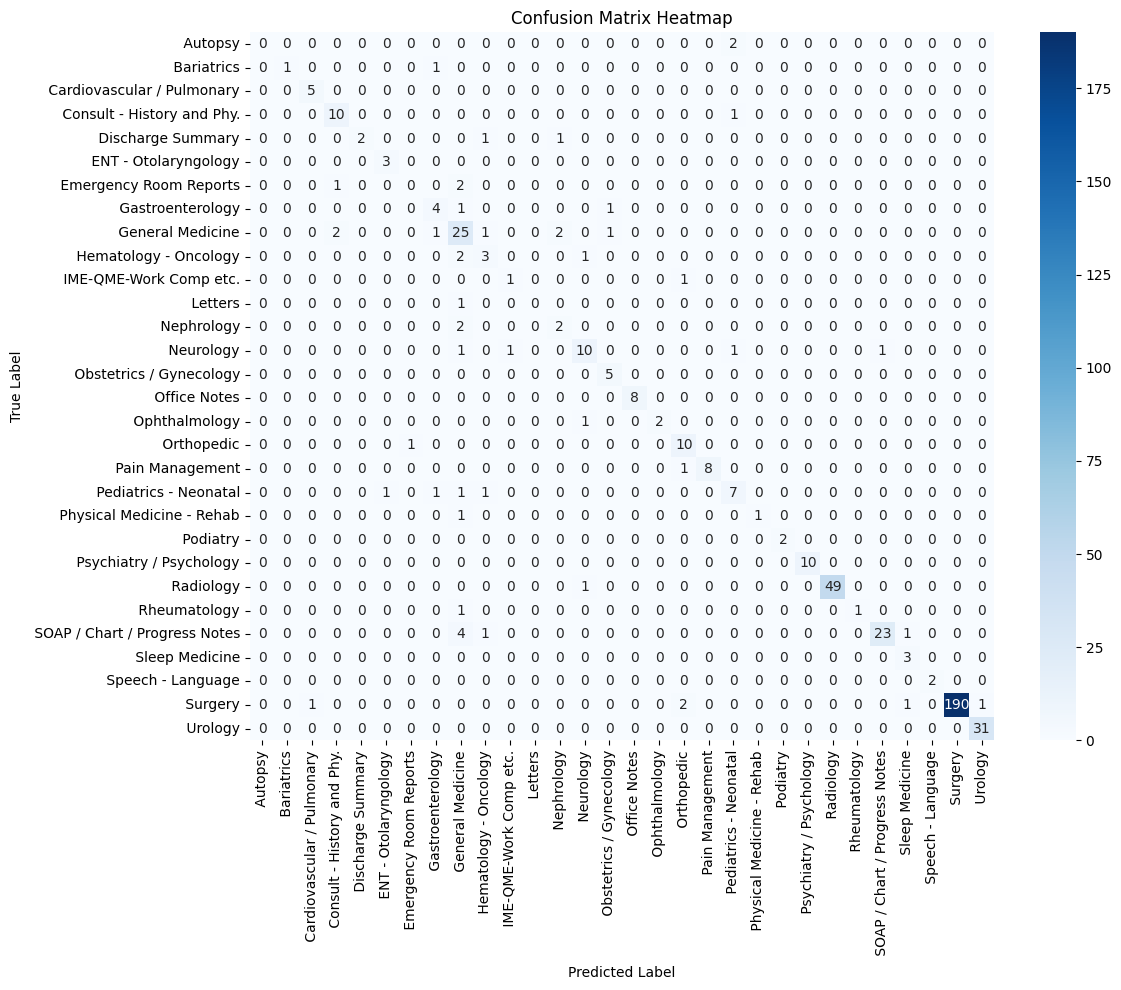

In [35]:
pred_test = trainer.predict(test_dataset)
y_test_pred = np.argmax(pred_test.predictions, axis=1)
y_test_true = pred_test.label_ids
used_labels_test = np.unique(np.concatenate([y_test_true, y_test_pred]))
label_names_test = label_encoder.classes_[used_labels_test]
cm = confusion_matrix(y_test_true, y_test_pred, labels=used_labels)

print("\nTest Classification Report:")
print(classification_report(y_test_true, y_test_pred, target_names=label_names_test, labels=used_labels_test))
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names,
            yticklabels=label_names,
            cbar=True)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()